## Introduction

This code was written for the 30DayMapChallenge for day 29 with the theme "Raster". In this script, a **3D digital elevation map** for the Nilgiris area, India is created using.

1.   The **Planetary Computer STAC API** for the digital elevation data using the pystac Python package. This avoids a manual download of the data.
2.   The Indian district **data from the DataMeet repository** and reading these data directly into Google Colab and extracting the Nilgiris area.
3. **rioxarray** to do the data processing  
4. The Python package **PyGMT**

In this script, I obtain a raster file for a Digital Elevation model using Pystac in Python.

For an overview of all the catalogs of different providers that have put their catalogues/data into STAC, please see the [stacindex.org](https://stacindex.org/) website.




## 1. Installing and loading the Python packages

In [34]:
!pip install pystac-client planetary-computer rioxarray --quiet

For the 3D map, we use the

In [35]:
# For installation in Google Colab:
# https://www.generic-mapping-tools.org/egu22pygmt/mars_maps_extended.html
## %%script echo skipping

# because I like to enjoy my coffee in silence, it takes time.
# (3 runs averaged 6 minutes to install everything ! keep drinking your coffee)
# comment the %%capture line if you want to see the colab VM working
%%capture
!sudo apt update
!sudo apt upgrade -y
!sudo apt install -y build-essential cmake libcurl4-gnutls-dev libnetcdf-dev gdal-bin libgdal-dev libfftw3-dev libpcre3-dev liblapack-dev libblas-dev libglib2.0-dev ghostscript ghostscript-x graphicsmagick ffmpeg xdg-utils
# clone gmt from source
!git clone --depth 50 https://github.com/GenericMappingTools/gmt
# cmake everything
!cmake /content/gmt
# build and install
!cmake --build . --target install

# and last but not least
!pip install pygmt

# and if you don't believe in it
!gmt --version
!python --version

In [36]:
import geopandas as gpd
import pandas as pd
import pygmt
import planetary_computer
import rioxarray as rxr

from pystac_client import Client
from rioxarray.merge import merge_arrays

## 2. Extracting the Nilgiris District

The district data are obtained from [DataMeet](https://github.com/datameet/maps/tree/master/Districts). The data can be pulled directly into Github. It is a shape file so several "subfiles" have to be pulled along with this:

https://github.com/datameet/maps/tree/master/Districts/Census_2011

In [37]:
!wget https://raw.githubusercontent.com/datameet/maps/master/Districts/Census_2011/2011_Dist.dbf
!wget https://raw.githubusercontent.com/datameet/maps/master/Districts/Census_2011/2011_Dist.prj
!wget https://raw.githubusercontent.com/datameet/maps/master/Districts/Census_2011/2011_Dist.shp
!wget https://raw.githubusercontent.com/datameet/maps/master/Districts/Census_2011/2011_Dist.shx

--2025-12-01 16:31:08--  https://raw.githubusercontent.com/datameet/maps/master/Districts/Census_2011/2011_Dist.dbf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54678 (53K) [application/octet-stream]
Saving to: ‘2011_Dist.dbf.4’

2011_Dist.dbf.4     100%[===================>]  53.40K  --.-KB/s    in 0.01s   

2025-12-01 16:31:08 (5.07 MB/s) - ‘2011_Dist.dbf.4’ saved [54678/54678]

--2025-12-01 16:31:09--  https://raw.githubusercontent.com/datameet/maps/master/Districts/Census_2011/2011_Dist.prj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

Read in the data into Geopandas and show a simple plot:

In [38]:
gdf = gpd.read_file('/content/2011_Dist.shp')

<Axes: >

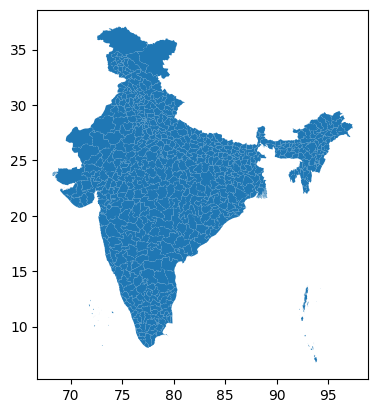

In [39]:
gdf.plot()

In [40]:
gdf.head()

,DISTRICT,ST_NM,ST_CEN_CD,DT_CEN_CD,censuscode,geometry
0,Adilabad,Andhra Pradesh,28,1,532,"POLYGON ((78.84972 19.7601, 78.85102 19.75945,..."
1,Agra,Uttar Pradesh,9,15,146,"POLYGON ((78.19803 27.4028, 78.19804 27.40278,..."
2,Ahmadabad,Gujarat,24,7,474,"MULTIPOLYGON (((72.03456 23.50527, 72.03337 23..."
3,Ahmadnagar,Maharashtra,27,26,522,"POLYGON ((74.67333 19.9467, 74.67393 19.93509,..."
4,Aizawl,Mizoram,15,3,283,"POLYGON ((92.98749 24.40453, 92.99107 24.40236..."


In [41]:
nilgiris = gdf[gdf["DISTRICT"] == "The Nilgiris"]


<Axes: >

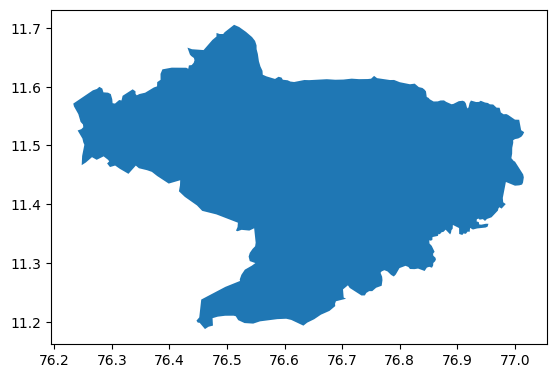

In [42]:
nilgiris.plot()

## 3. Extracting the elevation data

We extract the data from the OpenTopography and obtain the url from the stacindex.

We will use the shape file of Nilgiris to extract the data for the topography. However, it has to be in the right format for extraction using the pystac Python package:

In [43]:
nilgiris

,DISTRICT,ST_NM,ST_CEN_CD,DT_CEN_CD,censuscode,geometry
564,The Nilgiris,Tamil Nadu,33,10,611,"POLYGON ((76.84683 11.58238, 76.85013 11.58075..."


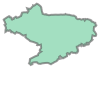

In [44]:
nilgiris = nilgiris.reset_index(drop=True)
geom = nilgiris['geometry'][0] # You need a shapely geometry
geom

In order to find the relevant link to the [OpenTopography catalogue in the STAC Index](https://stacindex.org/catalogs/opentopography#/), use the following command:

In [45]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace,)

In [46]:
collections = catalog.get_all_collections()

datasets = []
for col in collections:
    datasets.append({'collection': col.id, 'description': col.description})
df_col = pd.DataFrame(datasets)
## df_col # If you uncomment this, you can easily browse the table in Google Colab

In [47]:
df_col.shape

(126, 2)

One can find the

In [48]:
df_dem = df_col[df_col["collection"].str.contains("dem", case=False, na=False)]
df_dem

,collection,description
13,cop-dem-glo-30,The Copernicus DEM is a digital surface model ...
14,cop-dem-glo-90,The Copernicus DEM is a digital surface model ...
50,alos-dem,"The ""ALOS World 3D-30m"" (AW3D30) dataset is a ..."
74,nasadem,[NASADEM](https://earthdata.nasa.gov/esds/comp...


As an example, the cop-dem-glo-30 dataset is used:

In [49]:
items = catalog.search(
    collections=["cop-dem-glo-30"],
    intersects = geom
).item_collection()
len(items)

2

Print these items:

In [50]:
items_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
items_df

,geometry,gsd,datetime,platform,proj:shape,proj:transform,proj:code
0,"POLYGON ((77.99986 11.00014, 77.99986 12.00014...",30,2021-04-22T00:00:00Z,TanDEM-X,"[3600, 3600]","[0.0002777777777777778, 0.0, 76.99986111111112...",EPSG:4326
1,"POLYGON ((76.99986 11.00014, 76.99986 12.00014...",30,2021-04-22T00:00:00Z,TanDEM-X,"[3600, 3600]","[0.0002777777777777778, 0.0, 75.99986111111112...",EPSG:4326


We need to merge the two items as there are two rasters.

In [51]:
rasters = []

for item in items:
    href = item.assets["data"].href
    dem = rxr.open_rasterio(href)
    rasters.append(dem)

print("Loaded tiles:", len(rasters))

Loaded tiles: 2


In [52]:
rasters

[<xarray.DataArray (band: 1, y: 3600, x: 3600)> Size: 52MB
 [12960000 values with dtype=float32]
 Coordinates:
   * band         (band) int64 8B 1
   * y            (y) float64 29kB 12.0 12.0 12.0 12.0 ... 11.0 11.0 11.0 11.0
   * x            (x) float64 29kB 77.0 77.0 77.0 77.0 ... 78.0 78.0 78.0 78.0
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Point
     scale_factor:   1.0
     add_offset:     0.0,
 <xarray.DataArray (band: 1, y: 3600, x: 3600)> Size: 52MB
 [12960000 values with dtype=float32]
 Coordinates:
   * band         (band) int64 8B 1
   * y            (y) float64 29kB 12.0 12.0 12.0 12.0 ... 11.0 11.0 11.0 11.0
   * x            (x) float64 29kB 76.0 76.0 76.0 76.0 ... 77.0 77.0 77.0 77.0
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Point
     scale_factor:   1.0
     add_offset:     0.0]

Merge the two rasters:

In [53]:
merged_raster = merge_arrays(dataarrays = rasters)

In [54]:
merged_raster

<xarray.DataArray (band: 1, y: 3600, x: 7200)> Size: 104MB
array([[[832.0585  , 834.6837  , 835.91516 , ..., 464.61276 ,
         462.9806  , 461.6544  ],
        [830.9763  , 835.4224  , 836.96155 , ..., 465.4454  ,
         463.342   , 461.7499  ],
        [832.12305 , 834.2067  , 833.8266  , ..., 465.64676 ,
         463.67758 , 462.30383 ],
        ...,
        [ 75.32815 ,  76.19822 ,  75.5008  , ..., 170.48672 ,
         171.18375 , 171.54716 ],
        [ 75.885284,  75.70687 ,  72.86259 , ..., 170.58372 ,
         171.33511 , 171.56807 ],
        [ 72.32363 ,  71.818405,  70.19609 , ..., 170.08302 ,
         170.08113 , 171.47972 ]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 29kB 12.0 12.0 12.0 12.0 ... 11.0 11.0 11.0 11.0
  * x            (x) float64 58kB 76.0 76.0 76.0 76.0 ... 78.0 78.0 78.0 78.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

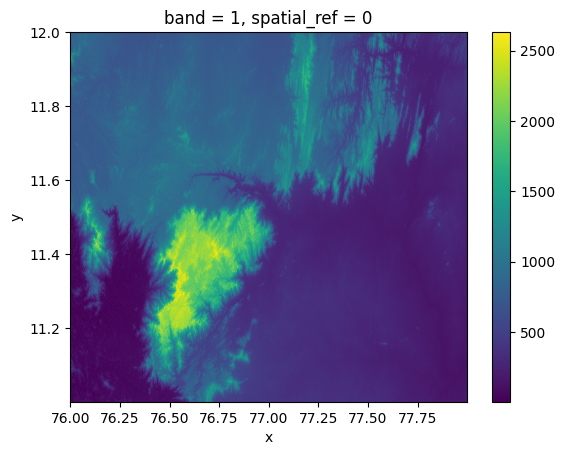

In [55]:
merged_raster.plot()

Clip this to the Nilgiris area but first check that the coordinate systems are the same:

In [56]:
print(f'It is {str(nilgiris.crs.to_epsg()) == items[0].properties['proj:code'].split(":")[1]} that shape file of the Nilgiris and the digital elevation are the same.')

It is True that shape file of the Nilgiris and the digital elevation are the same.


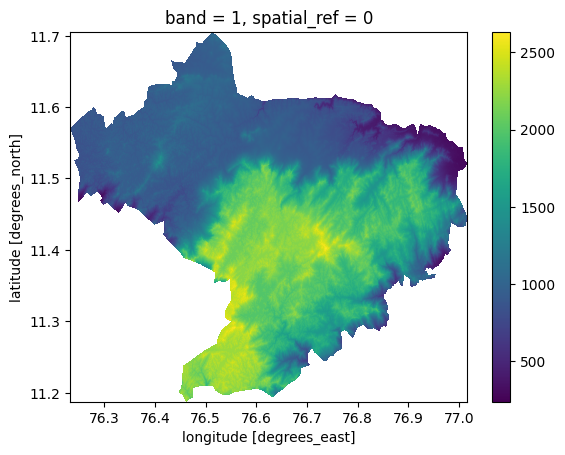

In [57]:
dem_clipped = merged_raster.rio.clip(nilgiris['geometry'])
dem_clipped.plot()

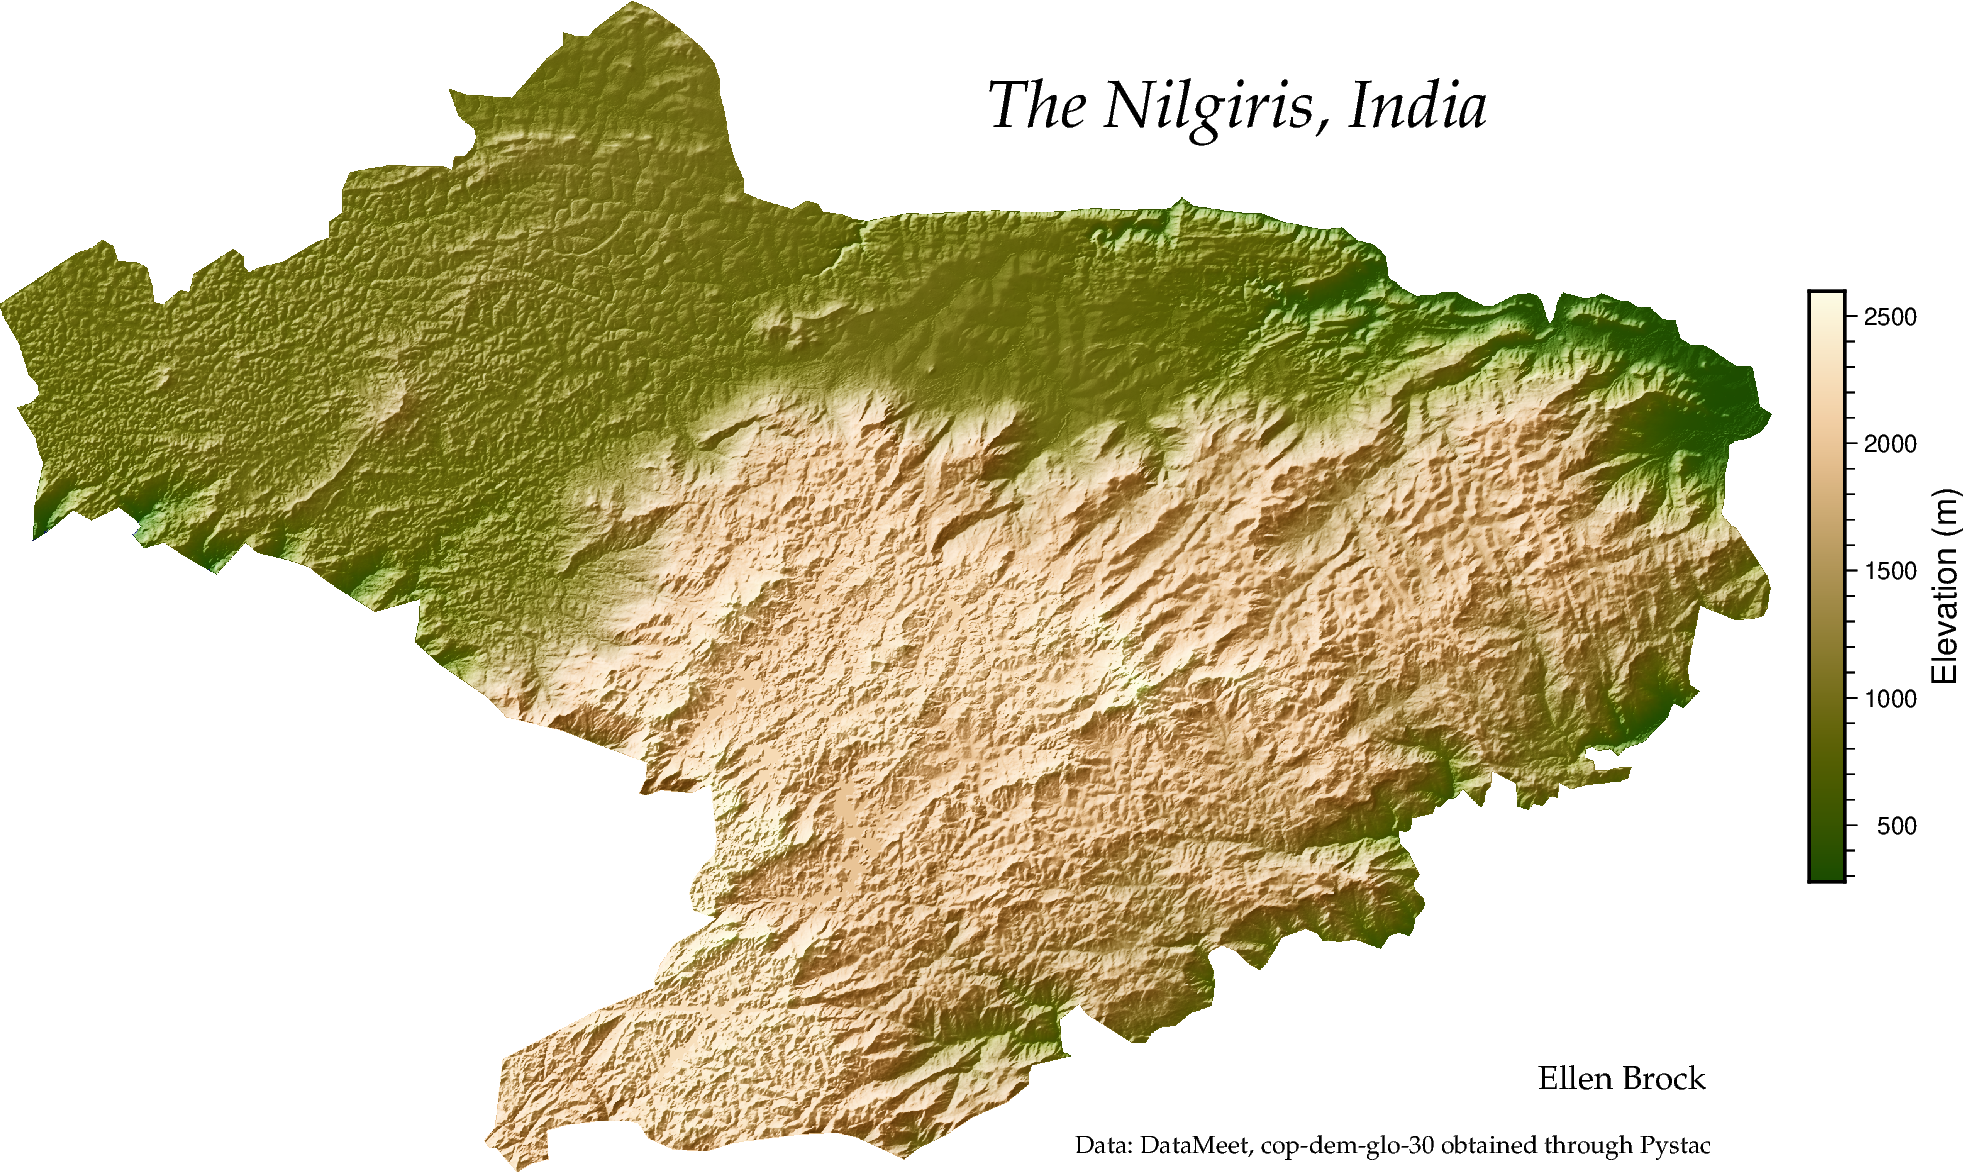

In [133]:
fig = pygmt.Figure()
fig.grdimage(grid=dem_clipped, cmap="oleron", frame=False, shading=True)
fig.colorbar(position="JMR+w5c/0.3c",   # width=8 cm, height=0.3 cm
    frame=["xaf+lElevation (m)"])
fig.text(text="The Nilgiris, India", x=76.78, y=11.66, font="16p,Palatino-Italic,black")
fig.text(text="Data: DataMeet, cop-dem-glo-30 obtained through Pystac ", x=76.85, y=11.20, font="6p,Palatino-Roman,black")
fig.text(text="Ellen Brock", x=76.95, y=11.23, font="8p,Palatino-Roman,black")
fig.savefig("nilgiris_clipped.png")
fig.show()

## References

https://www.pygmt.org/v0.2.1/tutorials/

https://www.generic-mapping-tools.org/agu24workshop/tut05_topography.html

https://github.com/Element84/geo-notebooks/blob/main/notebooks/odc-planetary-computer.ipynb

https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/